## <u>Efficient E-commerce Text Classification with Apache Sparke</u>


### Project Owner: Manuel Contreras

Dataset: https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification

### 1 - Libraries

In [117]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.sql.functions import length
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import functions as F

### 2 - Dataset Import and Data Cleaning

In [18]:
spark = SparkSession.builder.appName('NLP').getOrCreate()

In [19]:
file_path = r"C:\Users\manue\Desktop\DataScience\Datasets\ecommerceDataset.csv"

df = spark.read.csv(file_path)

df

DataFrame[_c0: string, _c1: string]

In [22]:
df.show()

+---------+--------------------+
|      _c0|                 _c1|
+---------+--------------------+
|Household|Paper Plane Desig...|
|Household|SAF 'Floral' Fram...|
|Household|SAF 'UV Textured ...|
|Household|SAF Flower Print ...|
|Household|Incredible Gifts ...|
|Household|Pitaara Box Roman...|
|Household|"Paper Plane Desi...|
|Household|Pitaara Box Roman...|
|Household|SAF 'Ganesh Moder...|
|Household|Paintings Villa U...|
|Household|Painting Mantra A...|
|Household|"Paper Plane Desi...|
|Household|Pitaara Box Roman...|
|Household|Painting Mantra '...|
|Household|Indianara Motivat...|
|Household|Tamatina Fabric R...|
|Household|SAF Flower Print ...|
|Household|Posterhouzz Comic...|
|Household|"ART DIOR | Set o...|
|Household|"ART DIOR | Danci...|
+---------+--------------------+
only showing top 20 rows



The Spark Datasets name columns in the following fashion _c*. I prefer renaming the columns, so I get a proper sense of what my data is about

In [25]:
df = df.withColumnRenamed('_c0', 'Class').withColumnRenamed('_c1', 'Comment')

In [27]:
df.show()

+---------+--------------------+
|    Class|             Comment|
+---------+--------------------+
|Household|Paper Plane Desig...|
|Household|SAF 'Floral' Fram...|
|Household|SAF 'UV Textured ...|
|Household|SAF Flower Print ...|
|Household|Incredible Gifts ...|
|Household|Pitaara Box Roman...|
|Household|"Paper Plane Desi...|
|Household|Pitaara Box Roman...|
|Household|SAF 'Ganesh Moder...|
|Household|Paintings Villa U...|
|Household|Painting Mantra A...|
|Household|"Paper Plane Desi...|
|Household|Pitaara Box Roman...|
|Household|Painting Mantra '...|
|Household|Indianara Motivat...|
|Household|Tamatina Fabric R...|
|Household|SAF Flower Print ...|
|Household|Posterhouzz Comic...|
|Household|"ART DIOR | Set o...|
|Household|"ART DIOR | Danci...|
+---------+--------------------+
only showing top 20 rows



The Dataset is transposing some comments to the class column, for an unknown reason to me. I decided to delete these cases, so they do not bother me going further from here.

In [30]:
unique_classes = df.select("Class").distinct()
unique_classes.show()

+--------------------+
|               Class|
+--------------------+
| Growing up in th...|
| This is a multif...|
| When I heard of ...|
| Bubbles makes pl...|
|           Household|
|               Books|
| Our Sodamakers i...|
| home. You can al...|
| turn plain drink...|
| The Sodamaker pl...|
|           Over time|
| In addition to t...|
| Who better to te...|
| You can be sure ...|
| Almost everybody...|
| In our business ...|
|    What has been...|
|         Electronics|
|Clothing & Access...|
| Combined with a ...|
+--------------------+
only showing top 20 rows



In [27]:
# Group by the 'Class' column and count the occurrences
class_counts = df.groupBy("Class").count()

# Show the results
class_counts.show()

+--------------------+-----+
|               Class|count|
+--------------------+-----+
| Growing up in th...|    2|
| This is a multif...|    2|
| When I heard of ...|    1|
| Bubbles makes pl...|    1|
|           Household|19313|
|               Books|11820|
| Our Sodamakers i...|    1|
| home. You can al...|    1|
| turn plain drink...|    1|
| The Sodamaker pl...|    1|
|           Over time|    1|
| In addition to t...|    1|
| Who better to te...|    2|
| You can be sure ...|    1|
| Almost everybody...|    1|
| In our business ...|    3|
|    What has been...|    3|
|         Electronics|10621|
|Clothing & Access...| 8671|
| Combined with a ...|    3|
+--------------------+-----+
only showing top 20 rows



In [32]:
# Filter the DataFrame to keep only rows with Household", "Books", "Electronics", "Clothing & Accessories as classes
df = df.filter(df["Class"].isin("Household", "Books", "Electronics", "Clothing & Accessories"))

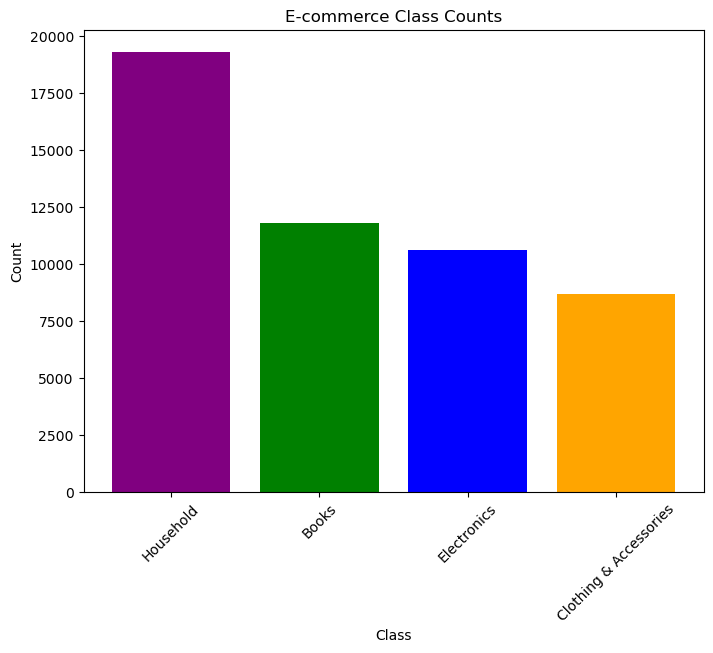

In [40]:
# counts as a pandas DataFrame for plotting
class_counts_df = class_counts.toPandas()

# bar chart
plt.figure(figsize=(8, 6))
plt.bar(class_counts_df["Class"], class_counts_df["count"], color=["purple", "green", "blue", "orange"])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("E-commerce Class Counts")
plt.xticks(rotation=45)
plt.show()

In [52]:
# There are null values thar are bothering when trying to tokenize
df.filter(df['comment'].isNull()).show()

+--------------------+-------+------+
|               Class|Comment|length|
+--------------------+-------+------+
|Clothing & Access...|   null|  null|
+--------------------+-------+------+



In [54]:
# Dropping rows with any null values and reassigning to df
df = df.dropna()

### 3 - Feature Engineering

In [46]:
df = df.withColumn('length', length(df['Comment']))
df.show()

+---------+--------------------+------+
|    Class|             Comment|length|
+---------+--------------------+------+
|Household|Paper Plane Desig...|  1338|
|Household|SAF 'Floral' Fram...|   346|
|Household|SAF 'UV Textured ...|  1316|
|Household|SAF Flower Print ...|  1091|
|Household|Incredible Gifts ...|   989|
|Household|Pitaara Box Roman...|  1745|
|Household|"Paper Plane Desi...|   192|
|Household|Pitaara Box Roman...|  1745|
|Household|SAF 'Ganesh Moder...|  1169|
|Household|Paintings Villa U...|   616|
|Household|Painting Mantra A...|   400|
|Household|"Paper Plane Desi...|   192|
|Household|Pitaara Box Roman...|  1745|
|Household|Painting Mantra '...|   609|
|Household|Indianara Motivat...|   102|
|Household|Tamatina Fabric R...|  1053|
|Household|SAF Flower Print ...|  1091|
|Household|Posterhouzz Comic...|   343|
|Household|"ART DIOR | Set o...|   480|
|Household|"ART DIOR | Danci...|   438|
+---------+--------------------+------+
only showing top 20 rows



In [65]:
# StringIndexes takes the column Class and converts the categories to numeric, so at the end, it is going to have values ranging from 0 to 3.
numeric_class = StringIndexer(inputCol='Class', outputCol='label')

# Tokenizer takes the column Comment, and transform the data in this way, for example, lets say that we have "I went running to Atlanta", after
# this transformation I will have [i, went, running, to, atlanta].
tokenizer = Tokenizer(inputCol='Comment', outputCol='token_text')

# StopWordsRemover gets rid of the most common words, in this case, from the english language. Taken the example from before, the result would be
# [went, running, atlanta]
stopword_remover = StopWordsRemover(inputCol='token_text', outputCol='token_stop')

#The CountVectorizer counts how many times a word appear in a document. For example, I have "i, am, manuel", and "i, am ,argentinian", this would be represented
# as (1,2,3,4). Lets say I have "I I Manuel", this would be (2,0,1,0) ---- Note: words between , and lowercase because it was previously tokenized,
count_vectorizer = CountVectorizer(inputCol='token_stop', outputCol='count_vec')

# IDF measures how important a word is in a document relative to a collection of documents. It combines two metrics:TF (Term Frequency) that counts how often 
# a word appears in a document and IDF (Inverse Document Frequency) which reduces the weight of common words across many documents.
idf = IDF(inputCol='count_vec', outputCol='tf-idf')

#VectorAssembler so I created a vector out of lenght and tf-idf
workedout_df = VectorAssembler(inputCols=['length', 'tf-idf'], outputCol='features')

In [79]:
# A Pipeline is used to automate a series of transformations on the data. It combines multiple stages, where each stage is a 
# data transformation or modeling step.

df_pipeline = Pipeline(stages=[numeric_class,
                           tokenizer,
                           stopword_remover,
                           count_vectorizer,
                           idf,
                           workedout_df])

In [81]:
final_df = df_pipeline.fit(df).transform(df)
final_df.show()

+---------+--------------------+------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|    Class|             Comment|length|label|          token_text|          token_stop|           count_vec|              tf-idf|            features|
+---------+--------------------+------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|Household|Paper Plane Desig...|  1338|  0.0|[paper, plane, de...|[paper, plane, de...|(168160,[1,3,5,6,...|(168160,[1,3,5,6,...|(168161,[0,2,4,6,...|
|Household|SAF 'Floral' Fram...|   346|  0.0|[saf, 'floral', f...|[saf, 'floral', f...|(168160,[3,6,22,3...|(168160,[3,6,22,3...|(168161,[0,4,7,23...|
|Household|SAF 'UV Textured ...|  1316|  0.0|[saf, 'uv, textur...|[saf, 'uv, textur...|(168160,[0,3,5,8,...|(168160,[0,3,5,8,...|(168161,[0,1,4,6,...|
|Household|SAF Flower Print ...|  1091|  0.0|[saf, flower, pri...|[saf, flower, pri...|(168160

In [83]:
final_df = df_pipe.fit(df).transform(df).select('label', 'features')
final_df.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(168161,[0,2,4,6,...|
|  0.0|(168161,[0,4,7,23...|
|  0.0|(168161,[0,1,4,6,...|
|  0.0|(168161,[0,1,4,6,...|
|  0.0|(168161,[0,1,3,4,...|
|  0.0|(168161,[0,1,4,16...|
|  0.0|(168161,[0,4,14,1...|
|  0.0|(168161,[0,1,4,16...|
|  0.0|(168161,[0,1,4,6,...|
|  0.0|(168161,[0,2,4,8,...|
|  0.0|(168161,[0,1,2,4,...|
|  0.0|(168161,[0,4,14,1...|
|  0.0|(168161,[0,1,4,16...|
|  0.0|(168161,[0,1,4,6,...|
|  0.0|(168161,[0,4,6,83...|
|  0.0|(168161,[0,1,5,14...|
|  0.0|(168161,[0,1,4,6,...|
|  0.0|(168161,[0,16,42,...|
|  0.0|(168161,[0,1,2,4,...|
|  0.0|(168161,[0,1,4,66...|
+-----+--------------------+
only showing top 20 rows



In [85]:
train, test = final_df.randomSplit([0.75, 0.25])

In [91]:
classifier = NaiveBayes(featuresCol='features', labelCol='label', predictionCol='prediction')

In [93]:
fitted_classifer = classifier.fit(train)

In [95]:
preds = fitted_classifer.transform(test)
preds.show()

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|(168161,[0,1,2,3,...|[-43431.148365990...|   [1.0,0.0,0.0,0.0]|       0.0|
|  0.0|(168161,[0,1,2,3,...|[-36459.386851354...|   [1.0,0.0,0.0,0.0]|       0.0|
|  0.0|(168161,[0,1,2,3,...|[-11688.150458657...|   [1.0,0.0,0.0,0.0]|       0.0|
|  0.0|(168161,[0,1,2,3,...|[-11688.150458657...|   [1.0,0.0,0.0,0.0]|       0.0|
|  0.0|(168161,[0,1,2,3,...|[-11960.609345603...|   [1.0,0.0,0.0,0.0]|       0.0|
|  0.0|(168161,[0,1,2,3,...|[-11851.763286808...|   [1.0,0.0,0.0,0.0]|       0.0|
|  0.0|(168161,[0,1,2,3,...|[-12031.352576110...|   [1.0,0.0,0.0,0.0]|       0.0|
|  0.0|(168161,[0,1,2,3,...|[-10030.929431632...|   [1.0,0.0,0.0,0.0]|       0.0|
|  0.0|(168161,[0,1,2,3,...|[-51049.519398934...|   [1.0,0.0,0.0,0.0]|       0.0|
|  0.0|(168161,[

In [97]:
# It is strange to me that I only see in the top 20 instances labelled as 0. I will explore further.
label_counts = preds.groupBy("label").count()
label_counts.show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0| 4861|
|  1.0| 2919|
|  3.0| 2162|
|  2.0| 2652|
+-----+-----+



Ok, it is a problem. The data is a bit umbalanced. Hopefully that will not impact negatively in the final metrics.

### 4 - Model Evaluation

In [105]:
# Evaluator for accuracy
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='accuracy')

In [107]:
# Accuracy
accuracy = evaluator.evaluate(preds)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9645863109417183


In [109]:
evaluator_f1 = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='f1')
f1_score = evaluator_f1.evaluate(preds)
print(f"F1 Score: {f1_score}")

F1 Score: 0.9645418633844949


In [111]:
evaluator_precision = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='weightedPrecision')
precision = evaluator_precision.evaluate(preds)
print(f"Weighted Precision: {precision}")

Weighted Precision: 0.9647064454218772


In [113]:
evaluator_recall = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='weightedRecall')
recall = evaluator_recall.evaluate(preds)
print(f"Weighted Recall: {recall}")

Weighted Recall: 0.9645863109417183


In [121]:
# predictions per class
correct_preds = preds.filter(preds['prediction'] == preds['label']) \
                     .groupBy('label') \
                     .count() \
                     .withColumnRenamed('count', 'correct_count')

# total instances per class
total_per_class = preds.groupBy('label').count() \
                       .withColumnRenamed('count', 'total_count')

# Join the two DataFrames to calculate per-class accuracy
accuracy_by_label = correct_preds.join(total_per_class, on='label', how='inner') \
                                 .withColumn('accuracy', F.col('correct_count') / F.col('total_count'))

# accuracy by label
accuracy_by_label.select('label', 'accuracy').show()

+-----+------------------+
|label|          accuracy|
+-----+------------------+
|  0.0|0.9728450936021394|
|  1.0| 0.947927372387804|
|  3.0|0.9861239592969473|
|  2.0|0.9502262443438914|
+-----+------------------+



### 4 - Conclussion

The model performs great, specially considering that the data is umbalanced. It reaches an accuracy of **0,96**. The accuracy for each class does not vary much either, ranging from 0,848